In [19]:
import torch
import torch.nn.functional as F
import pandas as pd
import re
import matplotlib.pyplot as plt

%matplotlib inline

In [7]:
# Get list of names from data
data = pd.read_csv('../data/companies_sorted.csv')
names = data['name'].tolist()

In [10]:
# Cut data to first million names to reduce training time - not looking for the most accurate anyway.
names = names[:1000000]

In [13]:
len(names)

1000000

In [20]:
# Build the vocabulary of characters and index mapping - to and from integers
# Involves making sure all the names are strings (as some are floats) and removing any names with non-alphanumeric characters
# (as some of these companies are from other countries and have non-English characters in their names).
# Maybe we should limit to US and UK companies only as the names are likely to be more similar and contain English words - extension.
names = [str(name) for name in names]
pattern = re.compile(r'^[a-zA-Z\d]+$')
filtered_names = [name for name in names if pattern.match(name)]
chars = sorted(list(set(''.join(filtered_names))))

In [21]:
len(chars)

36

In [24]:
stoi = {char: i+1 for i, char in enumerate(chars)}
stoi['.'] = 0
itos = {i: char for char, i in stoi.items()}

In [28]:
assert len(stoi) == len(chars) + 1, "Error: Vocabulary size does not match character set size"
assert len(stoi) == len(itos), "Error: Indexes to characters and characters to indexes do not match"

In [163]:
# Create x and y datasets from list of company names.
# I want two lists of lists, one for x and one for y
# x contain the first x letters of each name, each letter will be its own element of a list
# y contains the next letter
block_size = 3
X, Y = [], []
for name in filtered_names:
    # print(name)
    context = [0] * block_size
    for char in name + '.':
        ix = stoi[char]
        X.append(context)
        Y.append(ix)
        # print(''.join([itos[i] for i in context]), '-->', char)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)


In [85]:
# Create the embeddings for the characters.
# The embeddings will be a feature vector of length 10 for each character.
# The table of embeddings will be a matrix of size (vocab_size, embedding_size).

embedding_size = 10
vocab_size = len(stoi)

# Createa randn tensor of size (vocab_size, embedding_size) as the embeddings lookup table.
C = torch.randn(vocab_size, embedding_size)
# Apply these embeddings to the input data by using pytorch indexing.
embeddings = C[X]
embeddings.shape

torch.Size([17, 3, 10])

In [106]:
# Creating the first hidden layer.
# The input of this layer will be each of the characters in the context, input as their feature vectors (embeddings),
# the block_size (3) * embedding_size (10) = 30.
# The bias will be a vector of size 50, as the hidden layer has 50 outputs.
# In the paper, the hidden layer either has 0, 50, or 100 outputs.
# To get the activations of the hidden layer, we matrix multiply the inputs by the weights and add the bias, and 
# then apply the tanh activation function.

hidden_size = 50

W1 = torch.randn(block_size * embedding_size, hidden_size)
b1 = torch.randn(hidden_size)

h = torch.tanh(embeddings.view(-1, block_size * embedding_size) @ W1 + b1)

In [107]:
h.shape

torch.Size([17, 50])

In [123]:
# Create the output layer, which will take an input size of the output from the hidden layer (50)
# and output a vector of size vocab_size (37).
# With these numbers, we then need to normalise them, so we exponentiate them and divide by the sum of the exponentiated values.
# This gives us the probabilities of each character being the next character in the sequence.

W2 = torch.randn(hidden_size, vocab_size)
b2 = torch.randn(vocab_size)

logits = h @ W2 + b2
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)

In [135]:
# Calculate the loss of the model.
# The loss is the negative log likelihood of the correct character.
# We need to find the next character (Y), and look at the probability the model gives of the actual next character being
# the predicted next character by the model.

loss = -prob[torch.arange(len(Y)), Y].log().mean()
loss

tensor(12.9650)

## Refactored

In [173]:
X.shape, Y.shape

(torch.Size([1116580, 3]), torch.Size([1116580]))

In [193]:
g = torch.Generator().manual_seed(42)
C = torch.randn((vocab_size, embedding_size), generator=g, requires_grad=True)
W1 = torch.randn((block_size * embedding_size, hidden_size), generator=g, requires_grad=True)
b1 = torch.randn(hidden_size, generator=g, requires_grad=True)
W2 = torch.randn((hidden_size, vocab_size), generator=g, requires_grad=True)
b2 = torch.randn(vocab_size, generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

In [194]:
sum(p.nelement() for p in parameters)

3807

## Training Loop

In [195]:
lossi = []
stepi = []

training_steps = 100000

# Forward pass
for i in range(training_steps):
    stepi.append(i)

    # Mini batch
    ix = torch.randint(0, X.shape[0], (32,))

    # Forward pass
    embeddings = C[X[ix]]
    h = torch.tanh(embeddings.view(-1, block_size * embedding_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    lossi.append(loss.item())

    if i % 10000 == 0:
        print(f'{i}/{training_steps} --> {loss.item()}')

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update parameters
    for p in parameters:
        p.data += -0.1 * p.grad

0/100000 --> 16.571256637573242
10000/100000 --> 2.5918147563934326
20000/100000 --> 2.8205337524414062
30000/100000 --> 2.740307569503784
40000/100000 --> 2.885132074356079
50000/100000 --> 2.818249225616455
60000/100000 --> 2.5915589332580566
70000/100000 --> 2.6272459030151367
80000/100000 --> 2.586326837539673
90000/100000 --> 2.3683512210845947


In [196]:
loss

tensor(2.3580, grad_fn=<NllLossBackward0>)

## Refactored

In [214]:
def get_names(names, block_size=3):
    X, Y = [], []
    for name in names:
        context = [0] * block_size
        for char in name + '.':
            ix = stoi[char]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(filtered_names)
n1 = int(len(filtered_names) * 0.8)
n2 = int(len(filtered_names) * 0.9)

Xtr, Ytr = get_names(filtered_names[:n1])
Xdev, Ydev = get_names(filtered_names[n1:n2])
Xte, Yte = get_names(filtered_names[n2:])

torch.Size([892853, 3]) torch.Size([892853])
torch.Size([112084, 3]) torch.Size([112084])
torch.Size([111643, 3]) torch.Size([111643])


In [215]:
embedding_size = 10
vocab_size = len(stoi)
hidden_size = 100

In [216]:
g = torch.Generator().manual_seed(42)
C = torch.randn((vocab_size, embedding_size), generator=g, requires_grad=True)
W1 = torch.randn((block_size * embedding_size, hidden_size), generator=g, requires_grad=True)
b1 = torch.randn(hidden_size, generator=g, requires_grad=True)
W2 = torch.randn((hidden_size, vocab_size), generator=g, requires_grad=True)
b2 = torch.randn(vocab_size, generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

sum(p.nelement() for p in parameters)

7207

In [217]:
lossi = []
stepi = []

training_steps = 200000

# Forward pass
for i in range(training_steps):

    # Mini batch
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # Forward pass
    embeddings = C[Xtr[ix]]
    h = torch.tanh(embeddings.view(-1, block_size * embedding_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    if i % 10000 == 0:
        print(f'{i}/{training_steps} --> {loss.item()}')

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update parameters
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr* p.grad

    # Track stats
    stepi.append(i)
    lossi.append(loss.item())

0/200000 --> 18.434898376464844
10000/200000 --> 2.885880470275879
20000/200000 --> 2.5664989948272705
30000/200000 --> 3.15132474899292
40000/200000 --> 2.579885959625244
50000/200000 --> 2.6074788570404053
60000/200000 --> 2.4851465225219727
70000/200000 --> 2.9811277389526367
80000/200000 --> 2.9497334957122803
90000/200000 --> 2.43009090423584
100000/200000 --> 2.594923257827759
110000/200000 --> 2.6889758110046387
120000/200000 --> 2.8581900596618652
130000/200000 --> 2.6945888996124268
140000/200000 --> 2.3474886417388916
150000/200000 --> 3.120798349380493
160000/200000 --> 2.6329293251037598
170000/200000 --> 2.768908977508545
180000/200000 --> 2.889587163925171
190000/200000 --> 2.999350070953369


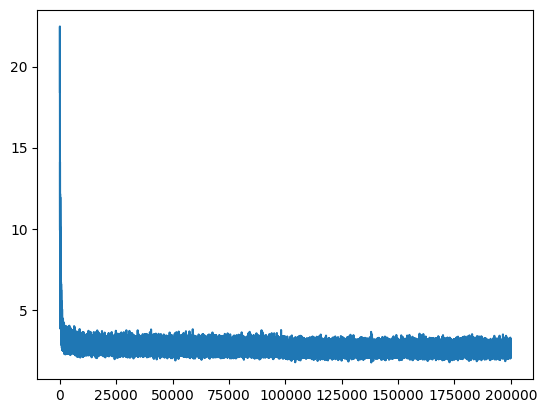

In [218]:
plt.plot(stepi, lossi)

In [219]:
@torch.no_grad()
def calc_loss(x, y):
    embeddings = C[x]
    h = torch.tanh(embeddings.view(-1, block_size * embedding_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(loss.item())

calc_loss(Xtr, Ytr)
calc_loss(Xdev, Ydev)

2.554370164871216
2.5546374320983887


embeddings=10 <br>
hidden_size=50 <br>
training=? <br>
train = 2.5987 <br>
dev = 2.5998 <br>
<br>
embeddings=10 <br>
hidden_size=100 <br>
training=200,000 <br>
train = 2.5544 <br>
dev = 2.5546 <br>

## Sampling from the Model

In [220]:
g_sample = torch.Generator().manual_seed(420)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        embeddings = C[torch.tensor([context])]
        h = torch.tanh(embeddings.view(-1, block_size * embedding_size) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs[0], 1, generator=g_sample).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join([itos[i] for i in out]))

hyrosimn.
shr.
dis.
brizia.
fcintech.
mca.
starawsb.
auvist.
clm.
corheletiama.
leteloftertek.
kcpoision.
mindrobenistetegradociono.
clrpildhmapio.
wpienqucanamtpesian.
sbarsmador.
inga2dentormariz.
gede.
jsspruse.
dol.
